# Openning data set and splitting to test, train, val

In [ ]:
# import splitfolders

In [2]:
# input_folder = "dataset"
# output_folder = "processed_data"
# splitfolders.ratio(input_folder, output_folder, seed=42, ratio=(.8,.1,.1))

In [3]:
# help(splitfolders.ratio)

# Importing required packages

In [1]:
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications.efficientnet import preprocess_input, decode_predictions, EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

# Preprocessing

In [2]:
img_height, img_weight = (224,224)
batch_size = 32

train_data_dir = r"processed_data\train"
valid_data_dir = r"processed_data\val"
test_data_dir = r"processed_data\test"

In [3]:
train_datagen =  ImageDataGenerator(preprocessing_function=preprocess_input,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    validation_split=0.4) # set as training data


train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size=(img_height, img_weight),
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    subset='training') # set as training data

valid_generator = train_datagen.flow_from_directory(valid_data_dir,
                                                    target_size=(img_height, img_weight),
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    subset='validation') # set as validation data

test_generator = train_datagen.flow_from_directory(test_data_dir,
                                                    target_size=(img_height, img_weight),
                                                    batch_size=1,
                                                    class_mode='categorical',
                                                    subset='validation',
                                                    shuffle=False ) # set as validation data

Found 1449 images belonging to 3 classes.
Found 119 images belonging to 3 classes.
Found 122 images belonging to 3 classes.


In [4]:
x, y = test_generator.next()
x.shape

(1, 224, 224, 3)

# Data analysis part

In [5]:
# Get a summary of the data distribution
train_data_counts = pd.Series(train_generator.classes).value_counts()
valid_data_counts = pd.Series(valid_generator.classes).value_counts()

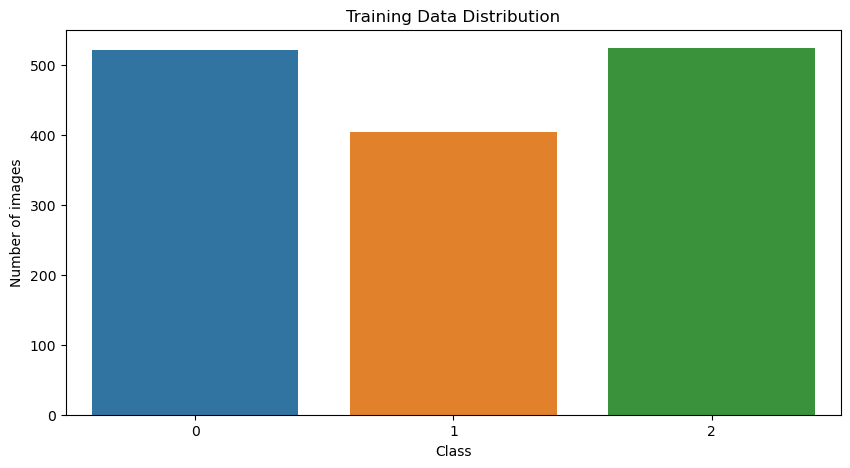

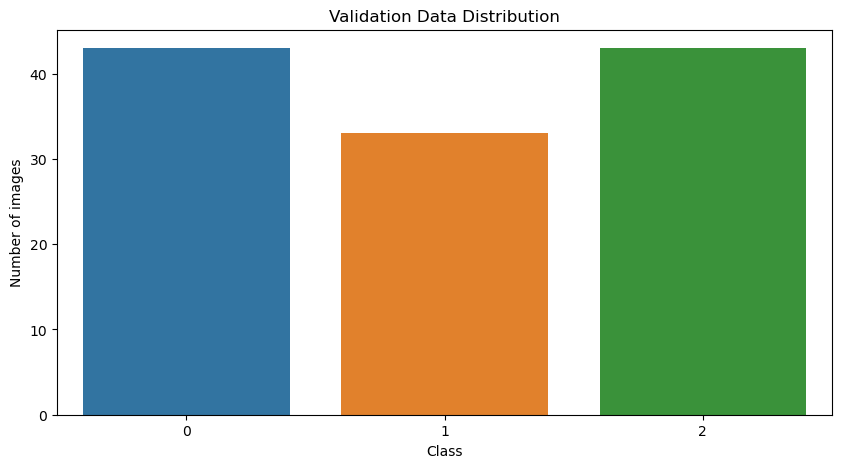

In [6]:
# Plot data distribution
plt.figure(figsize=(10, 5))
sns.barplot(x=train_data_counts.index, y=train_data_counts.values)
plt.title('Training Data Distribution')
plt.xlabel('Class')
plt.ylabel('Number of images')
plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(x=valid_data_counts.index, y=valid_data_counts.values)
plt.title('Validation Data Distribution')
plt.xlabel('Class')
plt.ylabel('Number of images')
plt.show()

# Modeling and Fitting

In [7]:
base_model = EfficientNetB0(include_top=False, weights='imagenet')
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [8]:
# model.summary()

# Freeze the layers of the base model

In [9]:
# for layer in base_model.layers:
#     layer.trainable = False

# Compile the model

In [10]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy'])

# Define EarlyStopping to prevent overfitting

In [11]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model

In [12]:
history = model.fit(train_generator, validation_data=valid_generator, epochs = 20, callbacks=[early_stop])

Epoch 1/20
46/46 [==============================] - 189s 4s/step - loss: 0.4788 - accuracy: 0.8130 - val_loss: 1.1209 - val_accuracy: 0.6387
Epoch 2/20
46/46 [==============================] - 183s 4s/step - loss: 0.2868 - accuracy: 0.8972 - val_loss: 2.4666 - val_accuracy: 0.5630
Epoch 3/20
46/46 [==============================] - 187s 4s/step - loss: 0.1881 - accuracy: 0.9365 - val_loss: 5.7738 - val_accuracy: 0.3950
Epoch 4/20
46/46 [==============================] - 181s 4s/step - loss: 0.1774 - accuracy: 0.9337 - val_loss: 3.5437 - val_accuracy: 0.6218
Epoch 5/20
46/46 [==============================] - 179s 4s/step - loss: 0.2160 - accuracy: 0.9268 - val_loss: 4.4600 - val_accuracy: 0.5210
Epoch 6/20
46/46 [==============================] - 184s 4s/step - loss: 0.1433 - accuracy: 0.9558 - val_loss: 1.6414 - val_accuracy: 0.6471


# save the model

In [13]:
model.save('model\efficiencynet\copra_grading_identification_effiencynet.h5')

C:\ProgramData\miniconda3\envs\copra\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


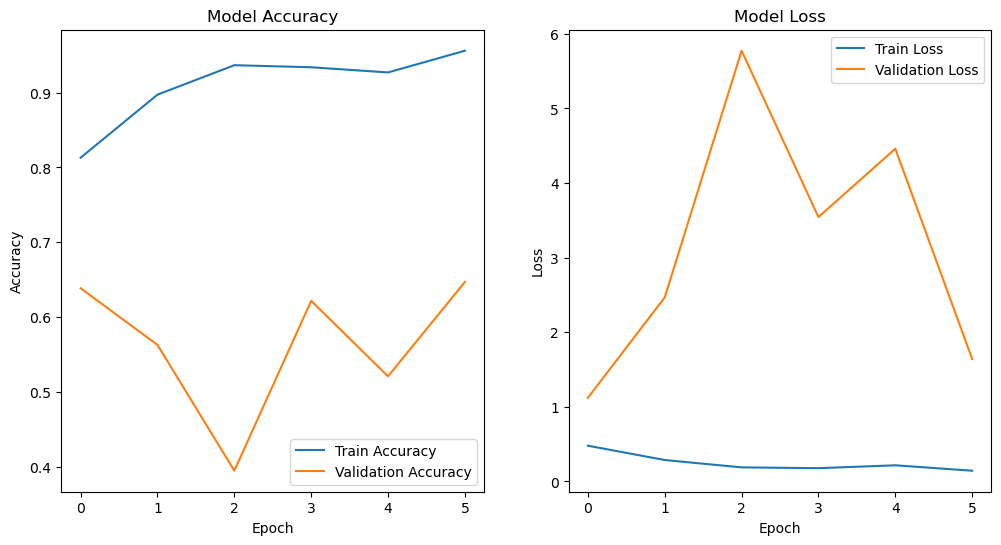

In [14]:
# Plot training & validation accuracy and loss values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

# Generate predictions

In [15]:
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Classification Report

In [16]:
print(classification_report(y_true, y_pred, target_names=class_labels))

               precision    recall  f1-score   support

Copra_Grade_A       0.66      0.57      0.61        44
Copra_Grade_B       0.31      0.24      0.27        34
Copra_Grade_C       0.66      0.86      0.75        44

     accuracy                           0.58       122
    macro avg       0.54      0.56      0.54       122
 weighted avg       0.56      0.58      0.56       122



# Confusion Matrix

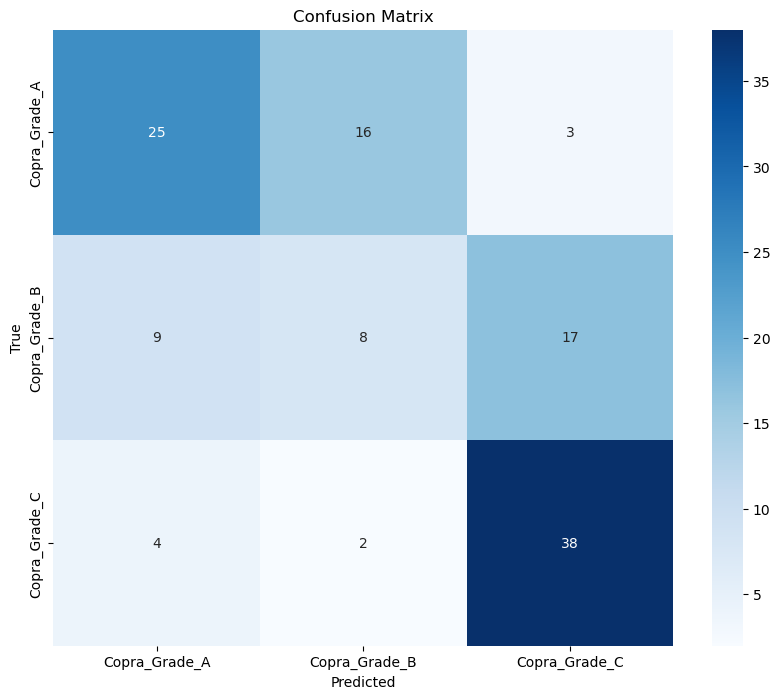

In [17]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Plot ROC Curves

In [2]:
plt.figure(figsize=(10, 8))
for i in range(len(class_labels)):
    fpr, tpr, _ = roc_curve(y_true == i, predictions[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {class_labels[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Plot Precision-Recall Curves
plt.figure(figsize=(10, 8))
for i in range(len(class_labels)):
    precision, recall, _ = precision_recall_curve(y_true == i, predictions[:, i])
    plt.plot(recall, precision, label=f'Class {class_labels[i]}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid()
plt.show()

NameError: name 'plt' is not defined

In [19]:
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print('\nTest Accuracy:', test_acc*100)

122/122 - 4s - loss: 1.3535 - accuracy: 0.6066

Test Accuracy: 60.65573692321777


# Testing

122/122 [==============================] - 5s 34ms/step


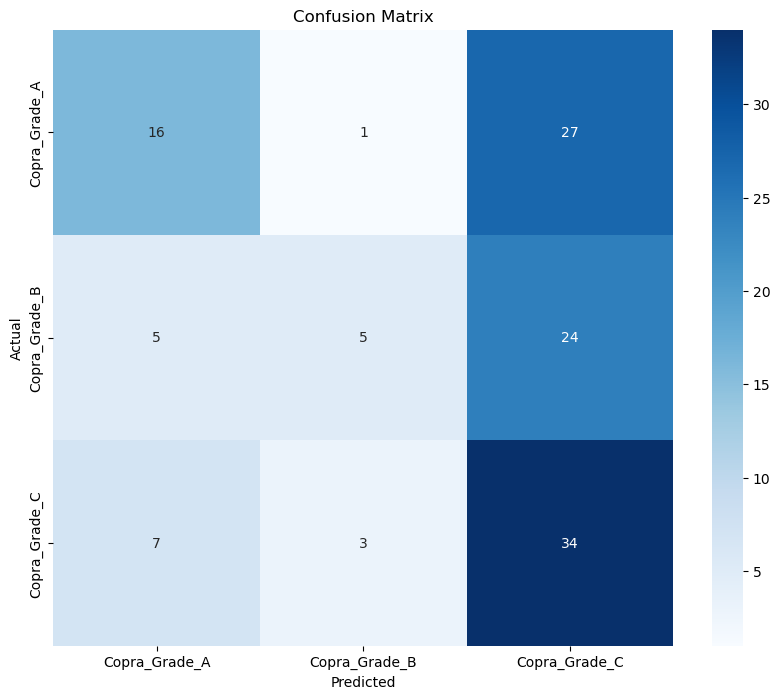

Confusion Matrix Accuracy: 45.08%
122/122 [==============================] - 5s 35ms/step - loss: 1.4384 - accuracy: 0.4590
Test Accuracy (model evaluation): 45.90%


In [20]:
import pandas as pd
import seaborn as sn
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Load the model
model = tf.keras.models.load_model('model/efficiencynet/copra_grading_identification_effiencynet.h5')

# Ensure test_generator is correctly configured
test_generator.reset()
predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)
y_prob = np.argmax(predictions, axis=1)  # Predicted class indices
y_act = test_generator.classes  # True class indices

# Class labels
class_labels = list(test_generator.class_indices.keys())
predicted_class = [class_labels[i] for i in y_prob]
actual_class = [class_labels[i] for i in y_act]

# Create DataFrame for confusion matrix
out_df = pd.DataFrame({'predicted_class': predicted_class, 'actual_class': actual_class})
confusion_matrix = pd.crosstab(out_df['actual_class'], out_df['predicted_class'],
                               rownames=['Actual'], colnames=['Predicted'])

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sn.heatmap(confusion_matrix, cmap='Blues', annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.show()

# Accuracy from Confusion Matrix
confusion_accuracy = np.diagonal(confusion_matrix).sum() / confusion_matrix.sum().sum()
print(f"Confusion Matrix Accuracy: {confusion_accuracy * 100:.2f}%")

# Model's Evaluation Accuracy
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy (model evaluation): {test_accuracy * 100:.2f}%")


# Convert to TensorFlow Lite

In [21]:
# Load your Keras model
model = tf.keras.models.load_model('model/efficiencynet/copra_grading_identification_effiencynet.h5')

# Convert the model to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model
with open('model/efficiencynet/copra_grading_identification.tflite', 'wb') as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\ASUSVI~1\AppData\Local\Temp\tmpreyeqeh1\assets


C:\ProgramData\miniconda3\envs\copra\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


# Optimize the TFLite Model

In [ ]:
# Post-training quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()

# Save the quantized TFLite model
with open('model/efficiencynet/copra_grading_identification_quant.tflite', 'wb') as f:
    f.write(tflite_quant_model)

INFO:tensorflow:Assets written to: C:\Users\Jamith\AppData\Local\Temp\tmpt436_4ya\assets


INFO:tensorflow:Assets written to: C:\Users\Jamith\AppData\Local\Temp\tmpt436_4ya\assets
C:\Users\Jamith\anaconda3\envs\copra\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
